Very dumbed-down version of what they do here: "Experimental Bayesian Calibration of Trapped-Ion Entangling Operations" (https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.3.020350).

- Instead of a simultaneous 4D calibration, here we do 4 1D calibrations. 
- Instead of cubic-spline interpolation, we do direct sampling. 
- Instead of a variable measurement strategy that minimizes the variance of the posterior based on sensitivity to phase and Rabi frequency, we go with a constant measurement strategy. 

Original noise parameters ($\sigma_\Omega, \sigma_\Delta, \sigma_\epsilon, \sigma_I$) based on the original paper (see Fig. 4)

Derivative noise parameters ($\sigma_I, \sigma_{f_{cl}}, \sigma_{\nu}$) based on **single_qubit_rotations/single_qubit_noise_sim.ipynb**.

In [1]:
# Run this cell to test if the LinearChain object is gonna give us a headache.
using IonSim

@time chain = LinearChain(
        ions=[Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")]), Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])], 
        comfrequencies=(x=3e6,y=3e6,z=2.5e5), selectedmodes=(;z=[1],)
    )
chain = Nothing;

  8.073205 seconds (14.89 M allocations: 957.963 MiB, 7.63% gc time, 99.58% compilation time: <1% of which was recompilation)


In [2]:
using QuantumOptics
import PyPlot
using Random, Distributions
using ProgressBars
Random.seed!(0)

include("./molmer_sorensen.jl")
using .MolmerSorensen: construct_MS_chamber
const plt = PyPlot;

using DelimitedFiles
using CSV
using DataFrames
using StringEncodings

The Molmer-Sorensen Hamiltonian: $\hat{H} = \frac{\Omega(t)}{2} \sum_{i=1,2} \Bigg[ \bigg( \hat{\sigma}_+^{(1)} + \hat{\sigma}_+^{(2)} \bigg) \otimes e^{i[\eta(\hat{a} e^{-i\nu t} + \hat{a}^\dagger e^{i \nu t} ) - \Delta_i t + \phi_i ) ] } \Bigg] + h.c.$

## 0. Setup

Global variables

In [35]:
######################### Optimal parameter values #########################
# See molmer_sorensen_scans_zoomed.ipynb for how these were determined
INTENSITY_MS = 94326.65907221894 # W/cm^2
TRAP_FREQUENCY = 2.5e5 # Hz
WAVELENGTH_CL_MS = 7.291469940286511e-7 # m
B_STRENGTH = 0.0005999899999999999; # T
PHASE = 0 # radians

######################### Parameter noise values #########################
# See molmer_sorensen_noise_sim.ipynb for how these were determined

# Intensity 
Œ©_opt = 1e7
Œ∫ = INTENSITY_MS/(Œ©_opt^2)
œÉ_Œ© = 0.2Œ©_opt
œÉ_I = Œ∫*sqrt(2*(œÉ_Œ©^4) + 4*(œÉ_Œ©^2)*Œ©_opt^2 )

Normal_I = Normal(INTENSITY_MS, œÉ_I)

# Center-line frequency
Œ¥Œª_MAX = 1e-15
C0 = 2.99792458e8
FREQUENCY_CL_MS = C0/WAVELENGTH_CL_MS
œÉ_f_cl = 2e3

Normal_f_cl = Normal(FREQUENCY_CL_MS, œÉ_f_cl)

# Trap frequency
œÉŒî = 2e3
œÉ_ŒΩ = œÉŒî
Normal_ŒΩ  = Normal(TRAP_FREQUENCY, œÉ_ŒΩ)

# Phase
œÉ_œï = 0.16*œÄ
Normal_œï = Normal(PHASE, œÉ_œï)

######################### Other global variables #########################

CALCIUM40 = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])
N_PARTICLES = Int(1e3)
FINITE_RWA_CUTOFF = 1e5

TIMESCALE = 1e-6 # seconds 
DETUNING = 1e4 # Hz
GATE_TIME = 1/DETUNING # seconds
T_RANGE = 0:GATE_TIME*1e-3:GATE_TIME
AC_CORRECTION = 0; # Hz
PI_TIME = 2e-6

# Intialize chamber object, whose properties will be updated in the loop
MS_CHAMBER_TUNED = construct_MS_chamber(
    TRAP_FREQUENCY,
    INTENSITY_MS,
    WAVELENGTH_CL_MS,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)

VIB_MODE = IonSim.modes(MS_CHAMBER_TUNED)[1] # first vibrational mode
ket0_VIB_MODE = VIB_MODE[0]
dm0_VIB_MODE = dm(ket0_VIB_MODE)

# Computational states 
ket_00 = CALCIUM40["S"] ‚äó CALCIUM40["S"]
ket_01 = CALCIUM40["S"] ‚äó CALCIUM40["D"]
ket_10 = CALCIUM40["D"] ‚äó CALCIUM40["S"]
ket_11 = CALCIUM40["D"] ‚äó CALCIUM40["D"]
œÅ_00 = dm(ket_00)
œÅ_01 = dm(ket_01)
œÅ_10 = dm(ket_10)
œÅ_11 = dm(ket_11)

# Bell states 
ket_00_m_i11 = (ket_00 - 1im*ket_11)/‚àö2
ket_00_p_i11 = (ket_00 + 1im*ket_11)/‚àö2
ket_01_m_i10 = (ket_01 - 1im*ket_10)/‚àö2
ket_01_p_i10 = (ket_01 + 1im*ket_10)/‚àö2
œÅ_00_m_i11 = dm(ket_00_m_i11)
œÅ_00_p_i11 = dm(ket_00_p_i11)
œÅ_01_m_i10 = dm(ket_01_m_i10)
œÅ_01_p_i10 = dm(ket_01_p_i10);

Helper functions 

In [36]:
# For loading CSV's into matrices 
function load_csv_to_matrix(fname)
    data = readdlm(fname)
    data = [split(line, ",") for line in data]
    data = [[parse(Float64, elem) for elem in row] for row in data]

    matrix = zeros((length(data), length(data[1])))
    for i in 1:length(data)
        matrix[i,:] = [elem for elem in data[i]]
    end
    return matrix
end

# For measuring ZZ
function ZZ_probs(œàf) # random projective measurement onto the computational basis
    p_00 = real(tr(œÅ_00 * œàf))
    p_11 = real(tr(œÅ_11 * œàf))
    p_01 = real(tr(œÅ_01 * œàf))
    p_10 = real(tr(œÅ_10 * œàf))

    return p_00, p_11, p_01, p_10
end

# For plotting state populations 
function plot_populations_double(chamber, tout, sol; title = Nothing)

    # compute expectation values
    prob_00 = expect(œÅ_00 ‚äó dm0_VIB_MODE , sol)  # ùîº(|S‚ü©|S‚ü©)
    prob_11 = expect(œÅ_11 ‚äó dm0_VIB_MODE, sol)  # ùîº(|D‚ü©|D‚ü©)
    prob_01 = expect(œÅ_01 ‚äó dm0_VIB_MODE, sol)  # ùîº(|S‚ü©|D‚ü©)
    prob_10 = expect(œÅ_10 ‚äó dm0_VIB_MODE, sol)  # ùîº(|D‚ü©|S‚ü©)
    prob_00_p_i11 = expect(œÅ_00_p_i11 ‚äó dm0_VIB_MODE, sol)  # ùîº(|S‚ü©|S‚ü© + i|D‚ü©|D‚ü©)
    prob_00_m_i11 = expect(œÅ_00_m_i11 ‚äó dm0_VIB_MODE, sol)  # ùîº(|S‚ü©|S‚ü© - i|D‚ü©|D‚ü©)
    prob_01_p_i10 = expect(œÅ_01_p_i10 ‚äó dm0_VIB_MODE, sol)  # ùîº(|S‚ü©|D‚ü© + i|D‚ü©|S‚ü©)
    prob_01_m_i10 = expect(œÅ_01_m_i10 ‚äó dm0_VIB_MODE, sol)  # ùîº(|S‚ü©|D‚ü© - i|D‚ü©|S‚ü©)

    # plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(tout, prob_00, label="00")
    ax1.plot(tout, prob_11, label="11")
    ax1.plot(tout, prob_01, label="01")
    ax1.plot(tout, prob_10, label="10")
    ax1.set_xlim(tout[1], tout[end])
    ax1.set_ylim(0, 1)
    ax1.legend(loc=1)
    ax1.set_xlabel("Time (Œºs)")
    ax1.set_ylabel("Population")
    ax1.set_title("Computational basis states")

    ax2.plot(tout, prob_00_p_i11, label="00 + i11")
    ax2.plot(tout, prob_00_m_i11, label="00 - i11")
    ax2.plot(tout, prob_01_p_i10, label="01 + i10")
    ax2.plot(tout, prob_01_m_i10, label="01 - i10")
    ax2.set_xlim(tout[1], tout[end])
    ax2.set_ylim(0, 1)
    ax2.legend(loc=1)
    ax2.set_xlabel("Time (Œºs)")
    ax2.set_ylabel("Population")
    ax2.set_title("Bell states")
    if title != Nothing
        fig.suptitle(title)
    end

    return fig
end

# For binning probability distributions
function bin_prior(particles, weights, n_bins)
    new_bins = zeros(n_bins)
    new_weights = zeros(n_bins)
    bin_width = (maximum(particles) - minimum(particles))/n_bins
    
    for i in 1:n_bins
        bin_start = minimum(particles) + (i-1)*bin_width
        bin_end = bin_start + bin_width
        new_bins[i] = mean([bin_start, bin_end])

        bin_filter = (particles .>= bin_start).&(particles .< bin_end)
        weight_in_bin = sum(weights[bin_filter])
        new_weights[i] = weight_in_bin
        
    end
    return new_bins, new_weights, bin_width
end

bin_prior (generic function with 1 method)

Test fidelity with optimal parameters

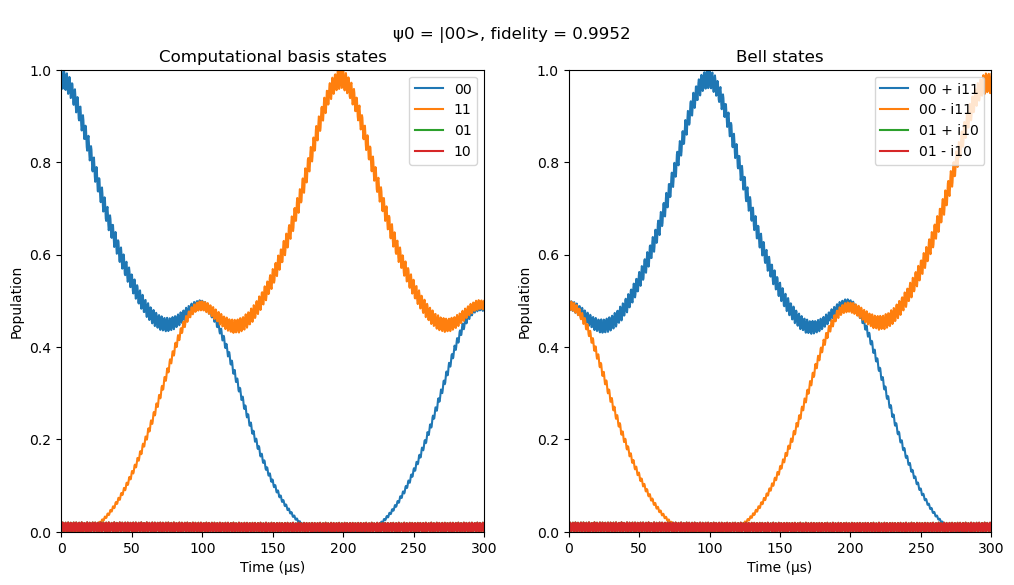

  0.332908 seconds (5.23 M allocations: 198.410 MiB, 18.40% gc time)
  0.287209 seconds (5.04 M allocations: 191.390 MiB, 9.11% gc time)


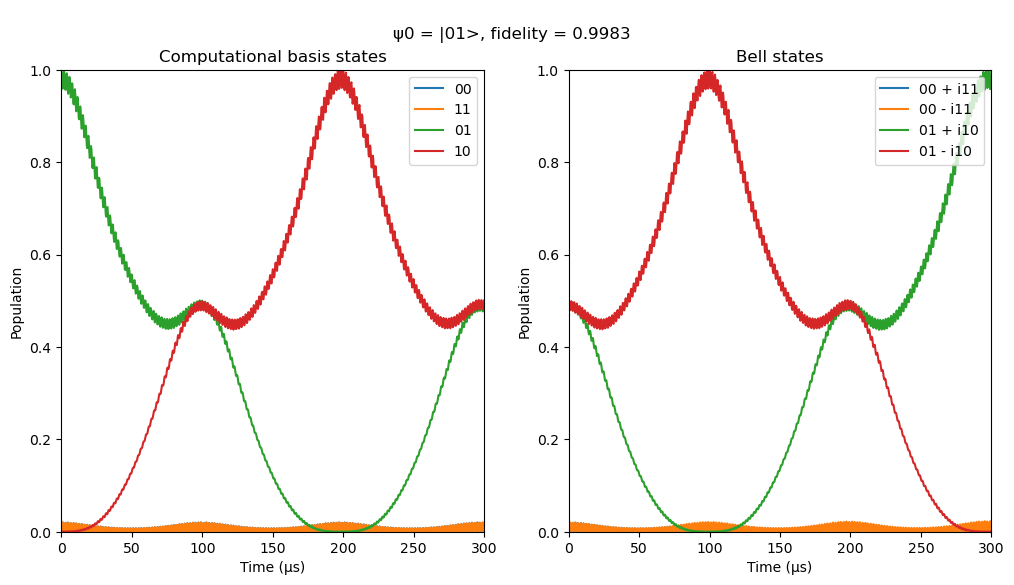

In [37]:
phase!(MS_CHAMBER_TUNED.lasers[1], 0)
phase!(MS_CHAMBER_TUNED.lasers[2], 0)

h = hamiltonian(MS_CHAMBER_TUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf);

@time tout00, sol00 = timeevolution.schroedinger_dynamic(3*T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h);
œÅ_final = ptrace(dm(sol00[end]), 3)
fid = round(real(fidelity(œÅ_final, œÅ_00_m_i11)), digits=4)
fig = plot_populations_double(MS_CHAMBER_TUNED, tout00, sol00)
fig.suptitle("\nœà0 = |00>, fidelity = $fid")
plt.display(fig)
plt.close(fig)

@time tout01, sol01 = timeevolution.schroedinger_dynamic(3*T_RANGE/TIMESCALE, ket_01 ‚äó ket0_VIB_MODE , h);
œÅ_final = ptrace(dm(sol01[end]), 3)

fid = round(real(fidelity(œÅ_final, œÅ_01_p_i10)), digits=4)
fig = plot_populations_double(MS_CHAMBER_TUNED, tout01, sol01)
fig.suptitle("\nœà0 = |01>, fidelity = $fid")
plt.display(fig)
plt.close(fig)


Functions to update true parameters, given measured parameters

### 1. Intensity
$\kappa = \frac{I}{\Omega^2} \Longrightarrow \Omega^2 = \frac{I}{\kappa} \Longrightarrow \Omega = \sqrt{\frac{I}{\kappa}}$

$\frac{\Omega_{\text{opt}}}{\overline{\Omega}} = \frac{\sqrt{I_{\text{opt}}/\kappa}}{\sqrt{\overline{I}/\kappa}} = \sqrt{\frac{I_{\text{opt}}}{\overline{I}}}$

In the text, they update: $t_g \to t_g \frac{\Omega_{\text{opt}}}{\overline{\Omega}}$

Since $t_g \sim I$, here we will update: $\boxed{I \to I \sqrt{\frac{I_{\text{opt}}}{\overline{I}}}}$

### 2. Center-line frequency

In the text, they update: $f_{\text{cl}} \to f_{\text{cl}} - (  \overline{\omega}_{\text{cl}} - \omega_{\text{cl, opt}} )$. 

**Mind the confusing notation**: here, $\omega_{\text{cl}}$ is not an angular frequency, they just use $\omega$ to denote the center-line *detuning* as opposed to the center-line frequency. With this in mind, it's clear that $\overline{\omega}_{\text{cl}} - \omega_{\text{cl, opt}}$ is exactly equivalent to $ \overline{f}_{\text{cl}} - f_{\text{cl, opt}}$. 

So we will update: $\boxed{f_{\text{cl}} \to f_{\text{cl}} - ( \overline{f}_{\text{cl}} - f_{\text{cl, opt}} )}$

### 3. Trap-frequency

In the text, they update: $f_{\text{sb}} \to f_{\text{sb}} - ( \overline{\delta} - \delta_{\text{opt}})$

So, once again, we simply update: $\boxed{\nu \to \nu - (\overline{\nu} - \nu_{\text{opt}})}$

### 4. Phase
$\boxed{\varphi \to \varphi - (\overline{\Delta \varphi} - \Delta \varphi_{\text{opt}})}$

In [38]:
# Intensity
function compute_I_new(chamber, I_bar)
    I = chamber.lasers[1].I(0)
    return I*sqrt(Œº_I/I_bar)
end

function update_intensity(chamber, I_new)
    intensity!(chamber.lasers[1], I_new)
    intensity!(chamber.lasers[2], I_new)
end

# Center-line frequency 
function compute_f_cl_new(chamber, f_cl_bar)
    Œª_cl = chamber.lasers[1].Œª
    f_cl = C0/Œª_cl
    return f_cl - (f_cl_bar - Œº_f_cl)
end

function update_f_cl(chamber, f_cl_new)
    wavelength!(chamber.lasers[1], C0/f_cl_new)
    wavelength!(chamber.lasers[2], C0/f_cl_new)
end

# Trap-frequency
function compute_ŒΩ_new(chamber, ŒΩ_bar)
    ŒΩ = chamber.iontrap.comfrequencies.z
    return ŒΩ - (ŒΩ_bar - Œº_ŒΩ)
end

function update_ŒΩ(chamber, ŒΩ_new)
    # Can't update the trap-frequency in-place
    # Must create a brand new chamber, with all the same properties except for the trap frequency
    I = chamber.lasers[1].I(0)
    Œª_cl = chamber.lasers[1].Œª
    chamber_new = construct_MS_chamber(
        ŒΩ_new,
        I,
        Œª_cl,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH
    )

    # Recall: The detuning is based on the *target* trap-frequency
    chamber.lasers[1].Œî = Œº_ŒΩ + DETUNING - AC_CORRECTION
    chamber.lasers[2].Œî = -(Œº_ŒΩ + DETUNING - AC_CORRECTION)
    return chamber_new
end 

# Phase
function compute_œï_new(chamber, œï_bar)
    œï = chamber.lasers[2].œï(0)
    return œï - (œï_bar - Œº_œï)
end

function update_œï(chamber, œï_new)
    phase!(chamber.lasers[2], œï_new)
end
 

update_œï (generic function with 1 method)

Run the noise-sim to check our parameter-update functions

In [39]:
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    Œº_ŒΩ,
    Œº_I,
    C0/Œº_f_cl,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
N_SAMPLES_TEST = Int(1e3)

fidelities = zeros(N_SAMPLES_TEST)
entanglement_entropies = zeros(N_SAMPLES_TEST)
for i in 1:N_SAMPLES_TEST
    if i%Int(1e2)==0
        print("\n", i)
        flush(stdout)
    end

    I_new = rand(Normal_I)[1]
    if I_new<0
        fidelities[i] = NaN
        entanglement_entropies[i] = NaN
        continue
    end

    f_cl_new = rand(Normal_f_cl)[1]
    Œª_cl_new = C0/f_cl_new
    Œ¥Œª = abs(WAVELENGTH_CL_MS - Œª_cl_new)
    if Œ¥Œª > Œ¥Œª_MAX
        fidelities[i] = NaN
        entanglement_entropies[i] = NaN
        continue
    end

    ŒΩ_new = rand(Normal_ŒΩ)[1]

    œï_new = rand(Normal_œï)[1]
    
    try
        # actual trap-frequency is ŒΩ
        update_intensity(MS_CHAMBER_UNTUNED, I_new)
        update_f_cl(MS_CHAMBER_UNTUNED, f_cl_new)
        update_œï(MS_CHAMBER_UNTUNED, œï_new)
        MS_CHAMBER_UNTUNED = update_ŒΩ(MS_CHAMBER_UNTUNED, ŒΩ_new)
        

        h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
        tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
        œÅ_final = dm(sol[end])
        œÅ_final_electronic = ptrace(œÅ_final, 3)
        fid_i = fidelity(œÅ_final_electronic, œÅ_00_p_i11)
        S_i = entropy_vn(œÅ_final_electronic)

        #@assert imag(fid) < 1e-8
        fidelities[i] = real(fid_i)
        entanglement_entropies[i] = S_i
    catch
        fidelities[i] = NaN
        entanglement_entropies[i] = NaN
    end
end

fidelities = fidelities[.~isnan.(fidelities)]
print("\nlength(fidelities) = ", length(fidelities))

entanglement_entropies = entanglement_entropies[.~isnan.(entanglement_entropies)]
print("\nlength(entanglement_entropies) = ", length(entanglement_entropies))

MS_CHAMBER_UNTUNED = Nothing;


100
200
300
400
500
600
700
800
900
1000
length(fidelities) = 998
length(entanglement_entropies) = 998

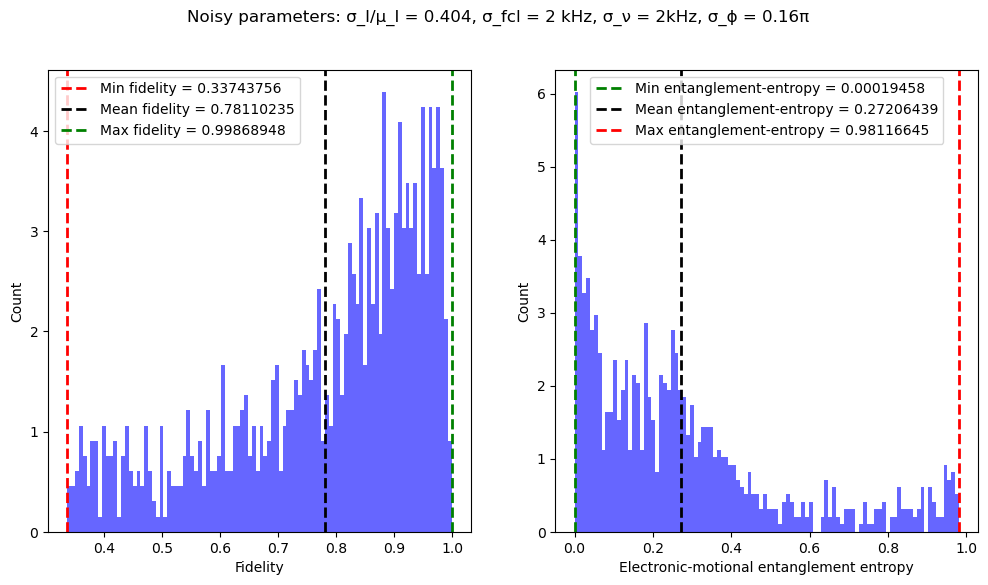

In [40]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.hist(fidelities, bins=100, density=true, alpha=0.6, color="b")
ax1.axvline(minimum(fidelities), color="r", linestyle="--", linewidth=2, label="Min fidelity = $(round(minimum(fidelities); digits=8))")
ax1.axvline(mean(fidelities), color="k", linestyle="--", linewidth=2, label="Mean fidelity = $(round(mean(fidelities); digits=8))")
ax1.axvline(maximum(fidelities), color="g", linestyle="--", linewidth=2, label="Max fidelity = $(round(maximum(fidelities); digits=8))")
ax1.set_xlabel("Fidelity")
ax1.set_ylabel("Count")
ax1.legend()

ax2.hist(entanglement_entropies, bins=100, density=true, alpha=0.6, color="b")
ax2.axvline(minimum(entanglement_entropies), color="g", linestyle="--", linewidth=2, label="Min entanglement-entropy = $(round(minimum(entanglement_entropies); digits=8))")
ax2.axvline(mean(entanglement_entropies), color="k", linestyle="--", linewidth=2, label="Mean entanglement-entropy = $(round(mean(entanglement_entropies); digits=8))")
ax2.axvline(maximum(entanglement_entropies), color="r", linestyle="--", linewidth=2, label="Max entanglement-entropy = $(round(maximum(entanglement_entropies); digits=8))")
ax2.set_xlabel("Electronic-motional entanglement entropy")
ax2.set_ylabel("Count")
ax2.legend()

fig.suptitle("Noisy parameters: œÉ_I/Œº_I = 0.404, œÉ_fcl = 2 kHz, œÉ_ŒΩ = 2kHz, œÉ_œï = 0.16œÄ")
plt.display(fig)
plt.close(fig)

# 1. 1D Bayesian parameter calibration: Intensity

$ P(\Theta|m) \propto P(m|\Theta) P(\Theta)$, up to some normalization

"The Bayesian inference requires an initial prior (i.e. $P(\Theta)$), and we must choose an initial set of particles to represent this prior. We choose a known continuous probability density function as prior."

For us: $\Theta = (I) \Longrightarrow P(\Theta) \sim \mathcal{N}(\mu_I, \sigma_I) $

$\Longrightarrow \boxed{P(\Theta) = \frac{1}{\sqrt{2\pi \sigma_I}} \exp\left[-\frac{1}{2}  \frac{(i - \mu_I)^2}{\sigma_I^2} \right]}  $

"We can then initialize the particle filter from that probability function by randomly sampling $N_p$ times from the distribution and setting all the weights to $1/N_p$."


## 1.a. Compute the initial prior

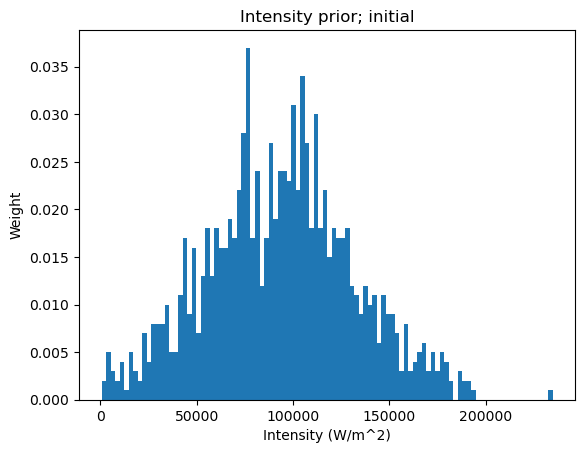

In [41]:
particles_I_1d = []
weights_I_1d = []

n_collected_I_1d = 0
while n_collected_I_1d < N_PARTICLES
    I_new = rand(Normal_I)[1]
    if I_new<0
        continue
    end

    append!(particles_I_1d, I_new)
    append!(weights_I_1d, 1.0)
    n_collected_I_1d += 1
end

weights_I_1d = weights_I_1d ./ sum(weights_I_1d);

particles_I_1d_binned, weights_I_1d_binned, binwidth_I_1d = bin_prior(particles_I_1d, weights_I_1d, 100)
fig = plt.figure()
plt.bar(particles_I_1d_binned, weights_I_1d_binned, width = binwidth_I_1d)
plt.xlabel("Intensity (W/m^2)")
plt.ylabel("Weight")
plt.title("Intensity prior; initial")
plt.display(fig)
plt.close(fig)

The $\texttt{weights\_1d}$ distribution is what gets updated throughout the calibration process. At each sample point $\widetilde{\Theta}^{(i)} \in \texttt{particles\_I\_1d}$, the relevant weight $w^{(i)} \in \texttt{weights\_1d}$ is updated according to:

$w_m^{(i)} \propto P(m|\widetilde{\Theta}^{(i)}) w^{(i)}$ 

(again, up to some normalization).

Now, there are two ways to *obtain* these $P(m|\widetilde{\Theta}^{(i)})$:
1. Numerical simulation at each discrete sample point.
2. Numerical simulation of an equally-spaced grid, then interpolation. 

In the paper, they go with the later because it's computationally cheaper. 

Here, we will go with the former because it's simpler and we are only calibrating one parameter.

## 1.b. Compute $P(m|\Theta)$

### 1.b.i. Define our measurement protocol $m$

"We restrict our considerations to sequences of MS gates without any local operations. Besides the number of gates $N_g$ we can also intentionally introduce a phase difference $\Delta \varphi_{\text{target}}$ between the gates. We restrict the phase difference settings to either $\Delta \varphi_{\text{target}} = 0$ or $\Delta \varphi_{\text{target}} = \pm \pi/4$, corresponding to either consecutive $U_{\text{MS}}^0 (\pi/2)$ gates or a sequence of $U_{\text{MS}}^0 (\pi/2) U_{\text{MS}}^{\pm \pi/4} (\pi/2) ... U_{\text{MS}}^{\pm (N_g-1)\pi/4} (\pi/2) $ gates. We choose these two types of sequences as they change which parameters the sequence is most sensitive to (Fig. 6)."

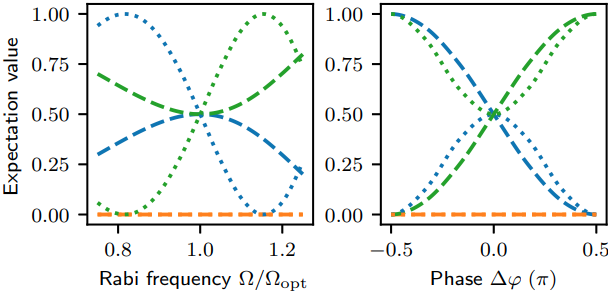

"FIG. 6. Expected outcome probabilities of $P(\ket{|g, g})$ (green), $P(\ket{|e, e})$  (blue), and $P(\ket{|e, g})  + P(\ket{|g, e})$ (orange) for a 3 $U_{\text{MS}}^0 (\pi/2)$ gate sequence (dotted) and for a $ U_{\text{MS}}^0 (\pi/2) U_{\text{MS}}^{\pi/4} (\pi/2) $ sequence (dashed). The first gate sequence is first-order insensitive to phase miscalibrations as the local minimum of the outcome probabilities around zero leads to only small variations in the likelihood of possible outcomes, and its symmetry around zero does not allow one to discriminate the sign of the miscalibration. Similar arguments can be used to see that this sequence is first-order sensitive to Rabi frequency miscalibrations. For the second gate sequence, the relation is inverted, being sensitive to phase miscalibrations at the cost of first-order insensitivity to the Rabi frequency. The qualitative behavior of the sensitivity of the center line matches the sensitivity of the phase difference, while the behavior of the sideband detuning matches the Rabi frequency."

Since we're not varying phase right now, let's stick with the first sequence of gates:
$N_g = 3 \Longrightarrow \boxed{m = U_{\text{MS}}^0 (\pi/2) U_{\text{MS}}^0 (\pi/2) U_{\text{MS}}^0 (\pi/2)} = U_{\text{MS}}^0 (3\pi/2)$

**TODO**: Consider a weighted-combination of Rabi-sensitive and phase-sensitive gates

**TODO**: Consider 50-50 split of $\psi_{\text{target}} = \frac{1}{\sqrt{2}} \left(\ket{00} + i\ket{11}\right)$ and $\psi_{\text{target}} = \frac{1}{\sqrt{2}} \left(\ket{01} + i\ket{10}\right)$ (or something else since this assumes perfect preparation of the initial state?)

### 1.b.ii. Compute $P(m|\widetilde{\Theta}^{(i)})$ by sampling $\texttt{particles\_I\_1d}$ and numerically integrating at that point.

**TODO:** Introduce depolarizing noise to account for SPAM error.

In [42]:
CONDITIONAL_I_DIST_COMPUTED = true

true

In [44]:
if CONDITIONAL_I_DIST_COMPUTED
    m_given_I_1d_dist = load_csv_to_matrix("m_given_I_1d_dist_$N_PARTICLES.csv")
else
    MS_CHAMBER_UNTUNED = construct_MS_chamber(
        Œº_ŒΩ,
        Œº_I,
        C0/Œº_f_cl,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH
    )
    phase!(MS_CHAMBER_UNTUNED.lasers[1], Œº_œï)
    phase!(MS_CHAMBER_UNTUNED.lasers[2], Œº_œï)

    m_given_I_1d_dist = zeros((N_PARTICLES, 4))

    for i in 1:N_PARTICLES

        if i%Int(1e2)==0
            print("\n", i)
            flush(stdout)
        end

        I_i = particles_I_1d[i]
        update_intensity(MS_CHAMBER_UNTUNED, I_i)

        h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
        tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
        œÅ_final = ptrace(dm(sol[end]),3)
        probs = ZZ_probs(œÅ_final)
        probs = probs ./ sum(probs)
        m_given_I_1d_dist[i, :] = [p for p in probs]
        
    end
    writedlm("m_given_I_1d_dist_$N_PARTICLES.csv",  m_given_I_1d_dist, ',')
    CONDITIONAL_I_DIST_COMPUTED = true
end;

## 1.c. Calibrate

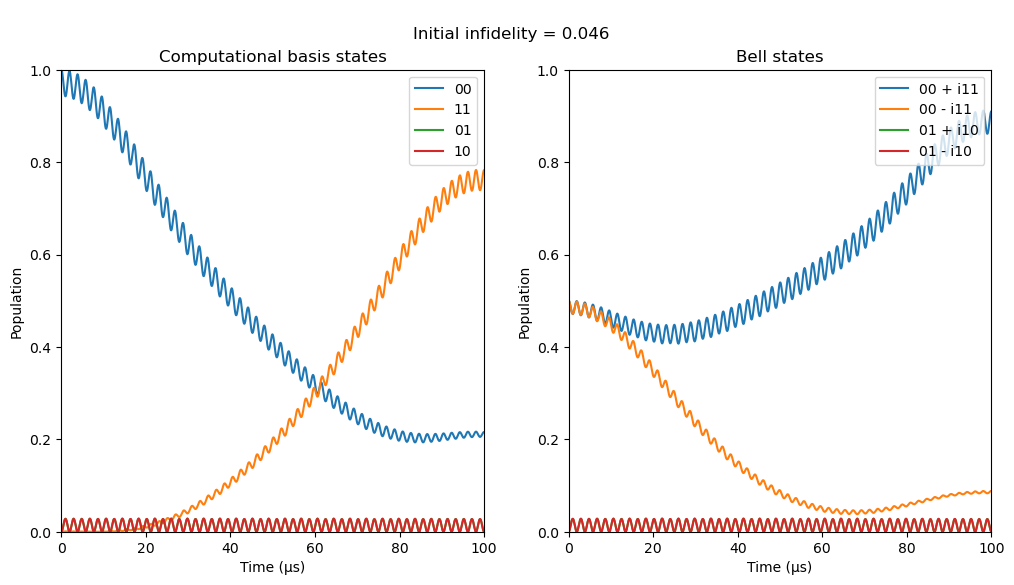

In [45]:
INFID_THRESH = 1.3e-2 # infidelity threshold
MAX_LOOPS = Int(1e3) # maximum number of loops
N_SHOTS = 100; # Number of shots per loop

# Initial theta
I_INITIAL = Œº_I + œÉ_I
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    Œº_ŒΩ,
    I_INITIAL,
    C0/Œº_f_cl,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
phase!(MS_CHAMBER_UNTUNED.lasers[1], Œº_œï)
phase!(MS_CHAMBER_UNTUNED.lasers[2], Œº_œï)

# Initial belief about theta
I_bar = sum(particles_I_1d .* weights_I_1d)

# Initial fidelity/infidelity
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
œÅ = ptrace(dm(sol[end]),3)
fid = fidelity(œÅ, œÅ_00_p_i11)
infid = 1 - real(fid)

fig = plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)
infid_title = round(infid, digits=4)
plt.suptitle("\nInitial infidelity = $infid_title")
plt.display(fig)
plt.close(fig)

In [47]:
loop = 0
I_infid_tracker = []
I_tracker = [I_INITIAL]
I_bar_tracker = [I_bar]
while infid > INFID_THRESH
    loop += 1
    if loop > MAX_LOOPS
        infid = 0
    end

    if loop%Int(1e1)==0
        print("\n", loop)
        flush(stdout)
    end

    # Perform measurements 
    h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
    œÅ = ptrace(dm(sol[end]),3)
    fid = fidelity(œÅ, œÅ_00_p_i11)
    infid = 1 - real(fid)
    probs = ZZ_probs(œÅ)
    probs = probs ./ sum(probs)
    m_t = rand(Categorical([p for p in probs]), N_SHOTS)

    # Update beliefs
    for i in 1:N_PARTICLES 
        w_i = weights_I_1d[i]
        theta_i = particles_I_1d[i]
        p_m_given_I_1d_dist = m_given_I_1d_dist[i, :]
        p_m = mean(p_m_given_I_1d_dist[m_t])
        weights_I_1d[i] = w_i * p_m
    end
    weights_I_1d = weights_I_1d ./ sum(weights_I_1d)
    I_bar = sum(particles_I_1d .* weights_I_1d)
    
    # Update parameters
    I_new = compute_I_new(MS_CHAMBER_UNTUNED, I_bar)
    I = I_new
    update_intensity(MS_CHAMBER_UNTUNED, I)

    append!(I_infid_tracker, infid)
    append!(I_tracker, I_new)
    append!(I_bar_tracker, I_bar)
    print("\nI = ", I, ", I_bar = ", I_bar, ", infid = ", infid)
    flush(stdout)


end


I = 156581.84835266223, I_bar = 96662.59073920661, infid = 0.12552569918129086
I = 154581.04674929625, I_bar = 96784.27376779189, infid = 0.11843134162018143
I = 152516.76025343244, I_bar = 96897.32710104068, infid = 0.11126147144680809
I = 150391.34707787412, I_bar = 97011.65121798731, infid = 0.104076416849191
I = 148211.0091155959, I_bar = 97122.3591003788, infid = 0.09690678578423628
I = 145978.30202556247, I_bar = 97234.1373442486, infid = 0.08979555876183132
I = 143707.5965511207, I_bar = 97331.09649226292, infid = 0.08277254971958059
I = 141408.15986699786, I_bar = 97419.29064234217, infid = 0.07590226528645094
I = 139080.9295557882, I_bar = 97509.7908671565, infid = 0.06922836100998087
10
I = 136730.78954641827, I_bar = 97597.11469567136, infid = 0.06276764792724943
I = 134363.65973170585, I_bar = 97679.50428764106, infid = 0.05654696316395269
I = 131985.18789796619, I_bar = 97756.96534455038, infid = 0.050593390976863994
I = 129593.4500659521, I_bar = 97840.51698277681, infid

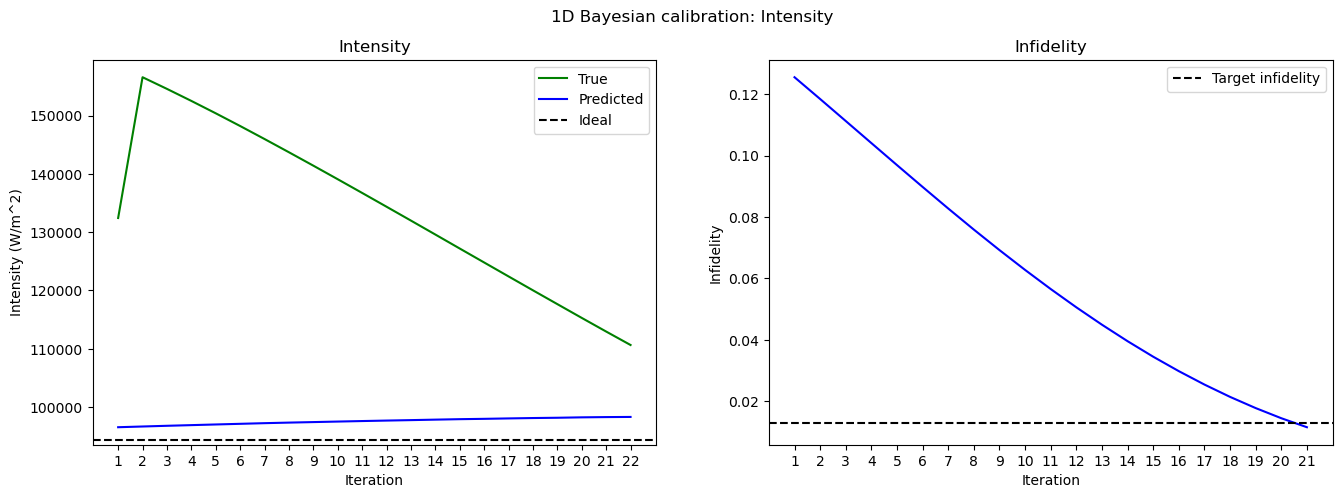

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

ax1.plot(1:length(I_tracker), I_tracker, color="g", label = "True")
ax1.plot(1:length(I_bar_tracker), I_bar_tracker, color="b", label = "Predicted")
ax1.axhline(INTENSITY_MS, color="k", linestyle="--", label = "Ideal")
ax1.set_xticks(ticks=1:length(I_tracker))
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Intensity (W/m^2)")
ax1.set_title("Intensity")
ax1.legend()


ax2.plot(1:length(I_infid_tracker), I_infid_tracker, color="b")
ax2.axhline(INFID_THRESH, label = "Target infidelity", color="k", linestyle="--")
ax2.set_xticks(ticks=1:length(I_infid_tracker))
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Infidelity")
ax2.set_title("Infidelity")
ax2.legend()

fig.suptitle("1D Bayesian calibration: Intensity")

plt.display(fig)
plt.close(fig)

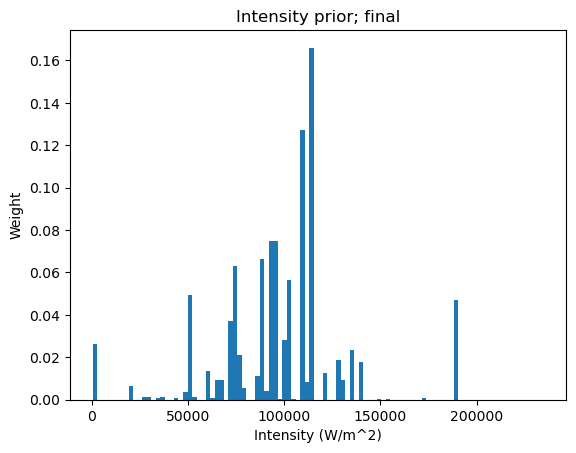

In [49]:
particles_I_1d_binned, weights_I_1d_binned, binwidth_I_1d = bin_prior(particles_I_1d, weights_I_1d, 100)
fig = plt.figure()
plt.bar(particles_I_1d_binned, weights_I_1d_binned, width = binwidth_I_1d)
plt.xlabel("Intensity (W/m^2)")
plt.ylabel("Weight")
plt.title("Intensity prior; final")
plt.display(fig)
plt.close(fig)

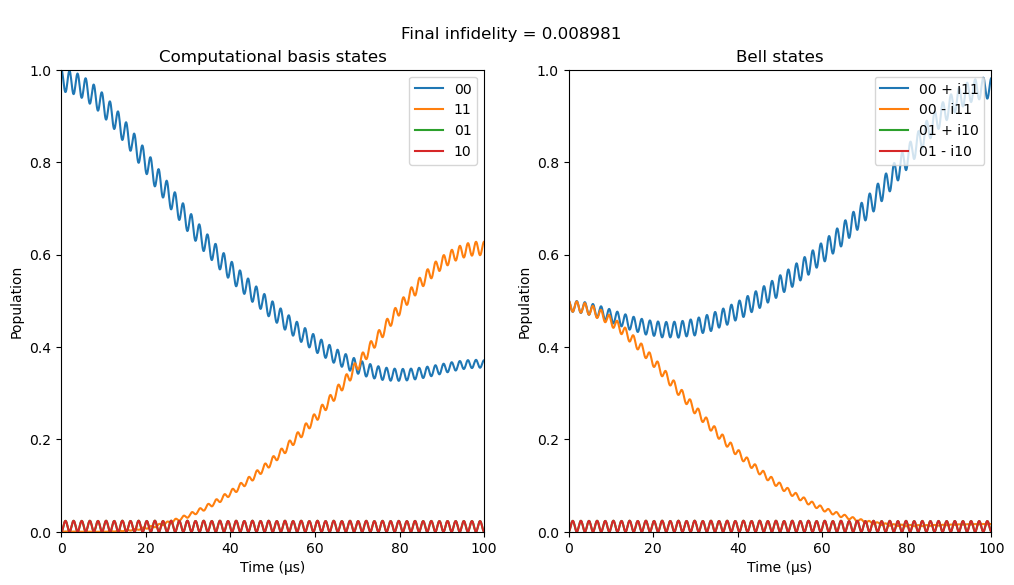


Final infidelity = 0.008981416744774595

In [50]:
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
œÅ = ptrace(dm(sol[end]),3)
fid = fidelity(œÅ, œÅ_00_p_i11)
infid = 1 - real(fid)
print("\nFinal infidelity = ", infid)

fig = plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)
infid_title = round(infid, digits=6)
plt.suptitle("\nFinal infidelity = $infid_title")
plt.display(fig)
plt.close(fig)

**IMPORTANT TODO:** Investigate runaway effect when $\texttt{I\_initial} < \texttt{INTENSITY\_MS}$ and $\texttt{INFID\_THRESH}$ is too small; recall Lukas: "the way you do the sampling is tricky, but important"

# 2. 1D Bayesian parameter calibration: Center-line frequency

$\Longrightarrow \boxed{P(\Theta) = \frac{1}{\sqrt{2\pi \sigma_{f_{\text{cl}}}}} \exp\left[-\frac{1}{2}  \frac{(i - \mu_{f_{\text{cl}}})^2}{\sigma_{f_{\text{cl}}}^2} \right]}  $

## 2.a. Compute the initial prior

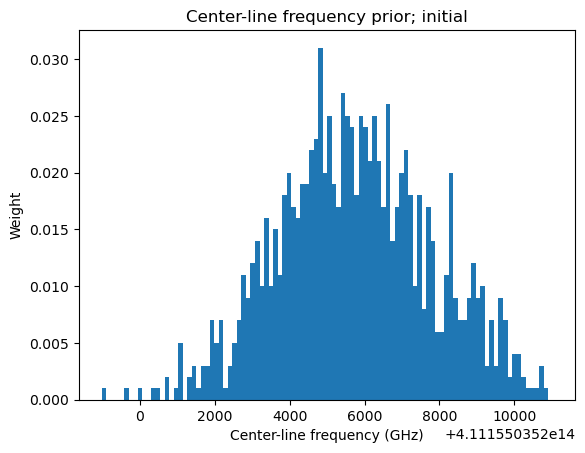

In [51]:
particles_f_cl_1d = []
weights_f_cl_1d = []

n_collected_f_cl_1d = 0
while n_collected_f_cl_1d < N_PARTICLES
    f_cl_new = rand(Normal_f_cl)[1]
    Œª_cl_new = C0/f_cl_new
    Œ¥Œª_cl_new = abs(C0/Œº_f_cl - Œª_cl_new)
    if Œ¥Œª_cl_new > Œ¥Œª_MAX
        continue
    end

    append!(particles_f_cl_1d, f_cl_new)
    append!(weights_f_cl_1d, 1.0)
    n_collected_f_cl_1d += 1
end

weights_f_cl_1d = weights_f_cl_1d ./ sum(weights_f_cl_1d);

particles_f_cl_1d_binned, weights_f_cl_1d_binned, binwidth_f_cl_1d = bin_prior(particles_f_cl_1d, weights_f_cl_1d, 100)
fig = plt.figure()
plt.bar(particles_f_cl_1d_binned, weights_f_cl_1d_binned, width = binwidth_f_cl_1d)
plt.xlabel("Center-line frequency (GHz)")
plt.ylabel("Weight")
plt.title("Center-line frequency prior; initial")
plt.display(fig)
plt.close(fig)

## 2.b. Compute $P(m|\Theta)$

In [52]:
CONDITIONAL_f_cl_DIST_COMPUTED = true

true

In [54]:
if CONDITIONAL_f_cl_DIST_COMPUTED
    m_given_f_cl_1d_dist = load_csv_to_matrix("m_given_f_cl_1d_dist_$N_PARTICLES.csv")
else
    MS_CHAMBER_UNTUNED = construct_MS_chamber(
        Œº_ŒΩ,
        Œº_I,
        C0/Œº_f_cl,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH
    )
    phase!(MS_CHAMBER_UNTUNED.lasers[1], Œº_œï)
    phase!(MS_CHAMBER_UNTUNED.lasers[2], Œº_œï)

    m_given_f_cl_1d_dist = zeros((N_PARTICLES, 4))

    for i in 1:N_PARTICLES

        if i%Int(1e2)==0
            print("\n", i)
            flush(stdout)
        end

        f_cl_i = particles_f_cl_1d[i]
        update_f_cl(MS_CHAMBER_UNTUNED, f_cl_i)

        h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
        tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
        œÅ_final = ptrace(dm(sol[end]),3)
        probs = ZZ_probs(œÅ_final)
        probs = probs ./ sum(probs)
        m_given_f_cl_1d_dist[i, :] = [p for p in probs]
    
    end
    writedlm("m_given_f_cl_1d_dist_$N_PARTICLES.csv",  m_given_f_cl_1d_dist, ',')
    CONDITIONAL_f_cl_DIST_COMPUTED = true 
end;

## 2.c. Calibrate

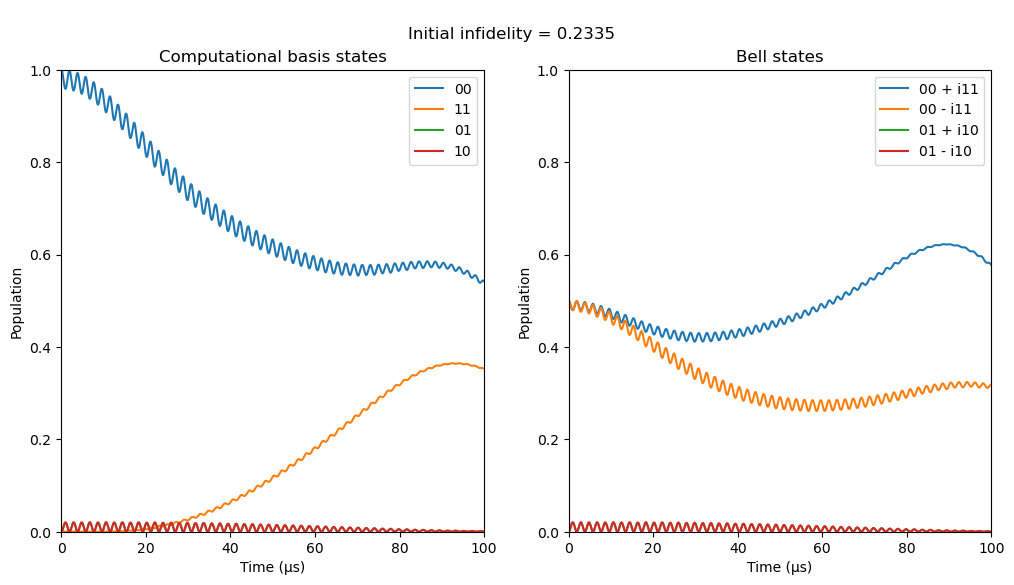


Initial infidelity = 0.2335463899139537

In [58]:
# Initial theta
F_CL_INITIAL = Œº_f_cl + œÉ_f_cl
Œª_CL_INITIAL = C0/F_CL_INITIAL
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    Œº_ŒΩ,
    Œº_I,
    C0/F_CL_INITIAL,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
phase!(MS_CHAMBER_UNTUNED.lasers[1], Œº_œï)
phase!(MS_CHAMBER_UNTUNED.lasers[2], Œº_œï)

# Initial belief about theta
f_cl_bar = sum(particles_f_cl_1d .* weights_f_cl_1d)

# Initial fidelity/infidelity
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
œÅ = ptrace(dm(sol[end]),3)
fid = fidelity(œÅ, œÅ_00_p_i11)
infid = 1 - real(fid)
print("\nInitial infidelity = ", infid)

fig = plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)
infid_title = round(infid, digits=4)
plt.suptitle("\nInitial infidelity = $infid_title")
plt.display(fig)
plt.close(fig)

In [59]:
loop = 0
f_cl_infid_tracker = []
f_cl_tracker = [F_CL_INITIAL]
f_cl_bar_tracker = [f_cl_bar]
while infid > INFID_THRESH
    loop += 1
    if loop > MAX_LOOPS
        break
    end

    print("\n\nf_cl = ", C0/MS_CHAMBER_UNTUNED.lasers[1].Œª, ", Œ¥Œª_cl = ", abs(MS_CHAMBER_UNTUNED.lasers[1].Œª - WAVELENGTH_CL_MS))

    # Perform measurements 
    h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
    œÅ = ptrace(dm(sol[end]),3)
    fid = fidelity(œÅ, œÅ_00_p_i11)
    infid = 1 - real(fid)
    probs = ZZ_probs(œÅ)
    probs = probs ./ sum(probs)
    m_t = rand(Categorical([p for p in probs]), N_SHOTS)

    # Update beliefs
    for i in 1:N_PARTICLES
        w_i = weights_f_cl_1d[i]
        theta_i = particles_f_cl_1d[i]
        p_m_given_f_cl_1d_dist = m_given_f_cl_1d_dist[i, :]
        p_m = mean(p_m_given_f_cl_1d_dist[m_t])
        weights_f_cl_1d[i] = w_i * p_m
    end
    weights_f_cl_1d = weights_f_cl_1d ./ sum(weights_f_cl_1d)
    f_cl_bar = sum(particles_f_cl_1d .* weights_f_cl_1d)
    
    # Update parameters
    f_cl_new = compute_f_cl_new(MS_CHAMBER_UNTUNED, f_cl_bar)
    Œª_cl_new = C0/f_cl_new
    Œ¥Œª_cl_new = abs(C0/Œº_f_cl - Œª_cl_new)
    if Œ¥Œª_cl_new > Œ¥Œª_MAX
        print("Runaway into non-integrable region")
        flush(stdout)
        break
    end
    update_f_cl(MS_CHAMBER_UNTUNED, f_cl_new)

    append!(f_cl_infid_tracker, infid)
    append!(f_cl_tracker, f_cl_new)
    append!(f_cl_bar_tracker, f_cl_bar)
    print(", f_cl_bar = ", f_cl_bar, "\nf_cl_new = ", f_cl_new,  ", Œ¥Œª_cl_new = ", abs(WAVELENGTH_CL_MS - C0/f_cl_new),  ", infid = ", infid)
    flush(stdout)

end



f_cl = 4.111550352077269e14, Œ¥Œª_cl = 3.546738708390569e-18, f_cl_bar = 4.11155035205761e14
f_cl_new = 4.1115503520769275e14, Œ¥Œª_cl_new = 3.4862817317802934e-18, infid = 0.2335463899139537

f_cl = 4.1115503520769275e14, Œ¥Œª_cl = 3.4862817317802934e-18, f_cl_bar = 4.111550352057737e14
f_cl_new = 4.1115503520764594e14, Œ¥Œª_cl_new = 3.403272502949372e-18, infid = 0.22732220652091772

f_cl = 4.1115503520764594e14, Œ¥Œª_cl = 3.403272502949372e-18, f_cl_bar = 4.111550352057841e14
f_cl_new = 4.111550352075887e14, Œ¥Œª_cl_new = 3.3017344283972627e-18, infid = 0.21885028501511483

f_cl = 4.111550352075887e14, Œ¥Œª_cl = 3.3017344283972627e-18, f_cl_bar = 4.111550352057925e14
f_cl_new = 4.1115503520752306e14, Œ¥Œª_cl_new = 3.1853732772682032e-18, infid = 0.20860142699063777

f_cl = 4.1115503520752306e14, Œ¥Œª_cl = 3.1853732772682032e-18, f_cl_bar = 4.1115503520580094e14
f_cl_new = 4.11155035207449e14, Œ¥Œª_cl_new = 3.05397729132538e-18, infid = 0.19701678389229194

f_cl = 4.11155035207449e

## 2.d. Analyze results

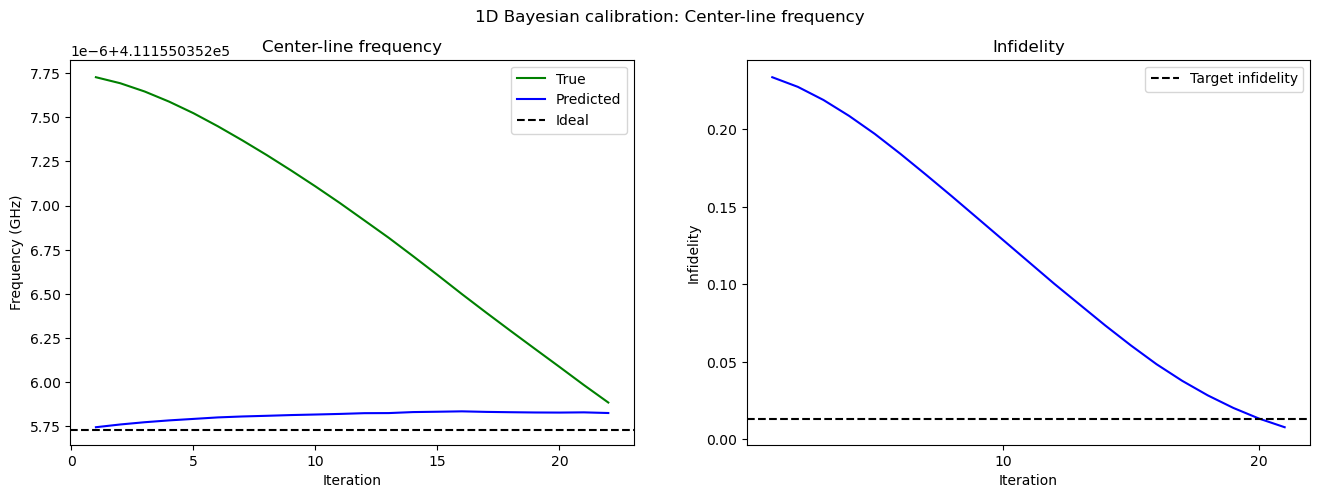

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

ax1.plot(1:length(f_cl_tracker), f_cl_tracker*1e-9, color="g", label = "True")
ax1.plot(1:length(f_cl_bar_tracker), f_cl_bar_tracker*1e-9, color="b", label = "Predicted")
ax1.axhline(FREQUENCY_CL_MS*1e-9, color="k", linestyle="--", label = "Ideal")
ax2.set_xticks(ticks=[i for i in 1:length(f_cl_tracker) if i%10==0])
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Frequency (GHz)")
ax1.set_title("Center-line frequency")
ax1.legend()


ax2.plot(1:length(f_cl_infid_tracker), f_cl_infid_tracker, color="b")
ax2.axhline(INFID_THRESH, label = "Target infidelity", color="k", linestyle="--")
ax2.set_xticks(ticks=[i for i in 1:length(f_cl_infid_tracker) if i%10==0])
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Infidelity")
ax2.set_title("Infidelity")
ax2.legend()

fig.suptitle("1D Bayesian calibration: Center-line frequency")

plt.display(fig)
plt.close(fig)

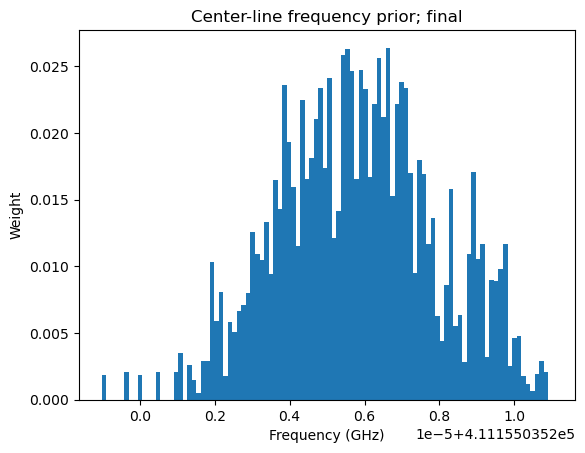

In [61]:
particles_f_cl_1d_binned, weights_f_cl_1d_binned, binwidth_f_cl_1d = bin_prior(particles_f_cl_1d, weights_f_cl_1d, 100)
fig = plt.figure()
plt.bar(particles_f_cl_1d_binned*1e-9, weights_f_cl_1d_binned, width = binwidth_f_cl_1d*1e-9)
plt.xlabel("Frequency (GHz)")
plt.ylabel("Weight")
plt.title("Center-line frequency prior; final")
plt.display(fig)
plt.close(fig)

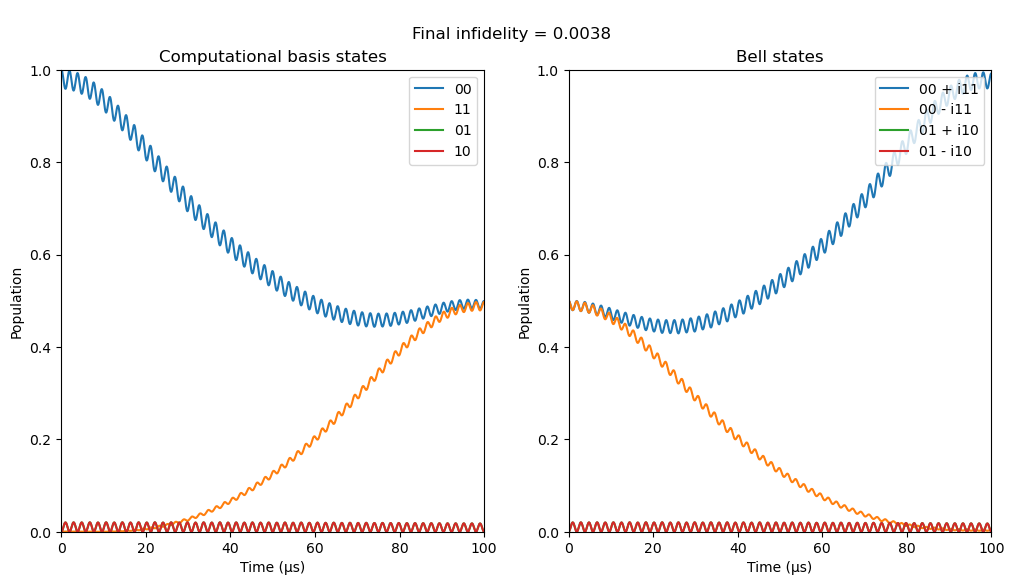

In [62]:
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
œÅ = ptrace(dm(sol[end]),3)
fid = fidelity(œÅ, œÅ_00_p_i11)
infid = 1 - real(fid)

fig = plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)
infid_title = round(infid, digits=4)
plt.suptitle("\nFinal infidelity = $infid_title")
plt.display(fig)
plt.close(fig)

**NOTE:** Sometimes it performs better using $\texttt{FINITE\_RWA\_CUTOFF = 5}$ rather than $\texttt{Inf}$

# 3. 1D Bayesian parameter calibration: trap frequency

## 3.a. Compute the initial prior

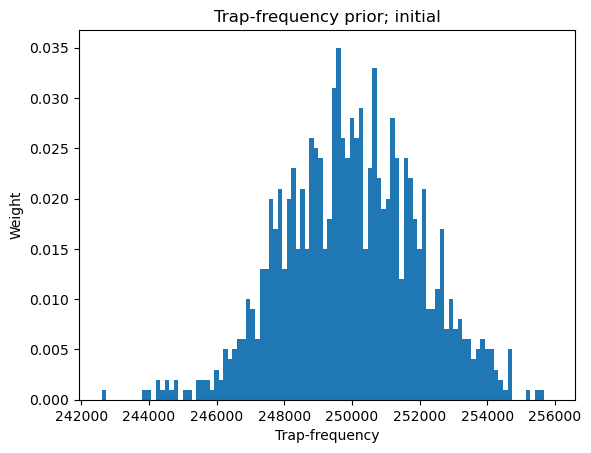

In [63]:
particles_ŒΩ_1d = []
weights_ŒΩ_1d = []

n_collected_ŒΩ_1d = 0
while n_collected_ŒΩ_1d < N_PARTICLES
    ŒΩ_new = rand(Normal_ŒΩ)[1]
    append!(particles_ŒΩ_1d, ŒΩ_new)
    append!(weights_ŒΩ_1d, 1.0)
    n_collected_ŒΩ_1d += 1
end

weights_ŒΩ_1d = weights_ŒΩ_1d ./ sum(weights_ŒΩ_1d);

particles_ŒΩ_1d_binned, weights_ŒΩ_1d_binned, binwidth_ŒΩ_1d = bin_prior(particles_ŒΩ_1d, weights_ŒΩ_1d, 100)
fig = plt.figure()
plt.bar(particles_ŒΩ_1d_binned, weights_ŒΩ_1d_binned, width = binwidth_ŒΩ_1d)
plt.xlabel("Trap-frequency")
plt.ylabel("Weight")
plt.title("Trap-frequency prior; initial")
plt.display(fig)
plt.close(fig)

## 3.b. Compute $P(m|\Theta)$

In [64]:
CONDITIONAL_ŒΩ_DIST_COMPUTED = true

true

In [65]:
if CONDITIONAL_ŒΩ_DIST_COMPUTED
    m_given_ŒΩ_1d_dist = load_csv_to_matrix("m_given_ŒΩ_1d_dist_$N_PARTICLES.csv")
else
    MS_CHAMBER_UNTUNED = construct_MS_chamber(
        Œº_ŒΩ,
        Œº_I,
        C0/Œº_f_cl,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH
    )

    m_given_ŒΩ_1d_dist = zeros((N_PARTICLES, 4))

    for i in 1:N_PARTICLES

        if i%Int(1e2)==0
            print("\n", i)
            flush(stdout)
        end

        try
            ŒΩ_i = particles_ŒΩ_1d[i]
            MS_CHAMBER_UNTUNED = update_ŒΩ(MS_CHAMBER_UNTUNED, ŒΩ_i)
            h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
            tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
            œÅ_final = ptrace(dm(sol[end]),3)
            probs = ZZ_probs(œÅ_final)
            probs = probs ./ sum(probs)
            m_given_ŒΩ_1d_dist[i, :] = [p for p in probs]
        catch
            m_given_ŒΩ_1d_dist[i, :] = [NaN for p in 1:4]
            particles_ŒΩ_1d[i] = NaN
            weights_ŒΩ_1d[i] = NaN
        end
    end
    writedlm("m_given_ŒΩ_1d_dist_$N_PARTICLES.csv",  m_given_ŒΩ_1d_dist, ',')
    CONDITIONAL_ŒΩ_DIST_COMPUTED = true 
end;

In [66]:
sum(isnan.(particles_ŒΩ_1d))

0

## 3.c. Calibrate

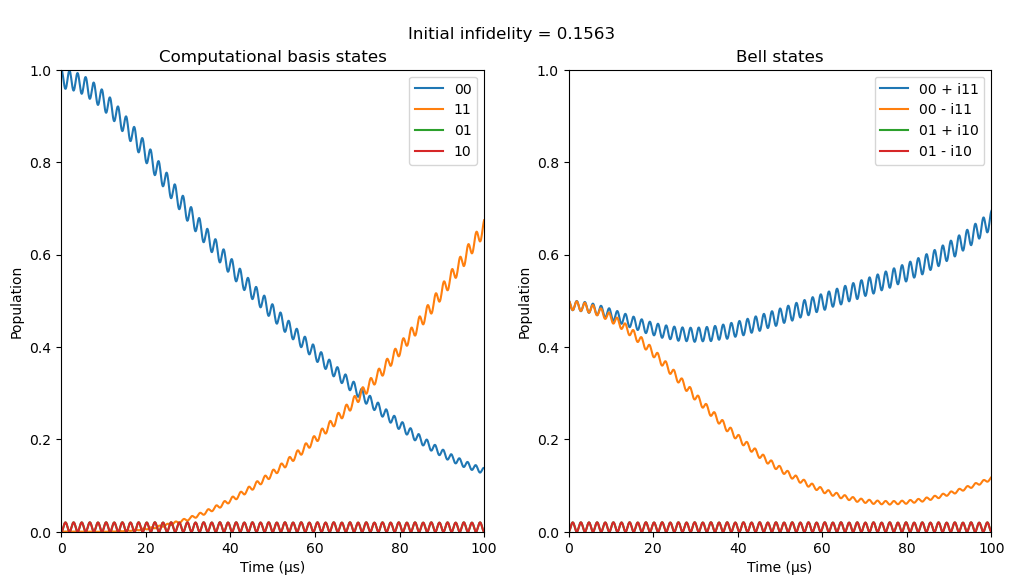

In [67]:
# Initial theta
ŒΩ_INITIAL = Œº_ŒΩ + œÉ_ŒΩ
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    ŒΩ_INITIAL,
    Œº_I,
    C0/Œº_f_cl,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
phase!(MS_CHAMBER_UNTUNED.lasers[1], Œº_œï)
phase!(MS_CHAMBER_UNTUNED.lasers[2], Œº_œï)

# Remember, the detuning is based on the target trap-frequency, not the true trap-frequency
MS_CHAMBER_UNTUNED.lasers[1].Œî = Œº_ŒΩ+ DETUNING - AC_CORRECTION
MS_CHAMBER_UNTUNED.lasers[2].Œî = -(Œº_ŒΩ + DETUNING - AC_CORRECTION)

# Initial belief about theta
ŒΩ_bar = sum(particles_ŒΩ_1d .* weights_ŒΩ_1d)

# Initial fidelity/infidelity
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
œÅ = ptrace(dm(sol[end]),3)
fid = fidelity(œÅ, œÅ_00_p_i11)
infid = 1 - real(fid)

fig = plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)
infid_title = round(infid, digits=4)
plt.suptitle("\nInitial infidelity = $infid_title")
plt.display(fig)
plt.close(fig)

In [68]:
loop = 0
ŒΩ_infid_tracker = []
ŒΩ_tracker = [ŒΩ_INITIAL]
ŒΩ_bar_tracker = [ŒΩ_bar]
while infid > INFID_THRESH
    loop += 1
    if loop > MAX_LOOPS
        break
    end

    # Perform measurements 
    h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
    œÅ = ptrace(dm(sol[end]),3)
    fid = fidelity(œÅ, œÅ_00_p_i11)
    infid = 1 - real(fid)
    probs = ZZ_probs(œÅ)
    probs = probs ./ sum(probs)
    m_t = rand(Categorical([p for p in probs]), N_SHOTS)

    # Update beliefs
    for i in 1:N_PARTICLES
        w_i = weights_ŒΩ_1d[i]
        theta_i = particles_ŒΩ_1d[i]
        p_m_given_ŒΩ_1d_dist = m_given_ŒΩ_1d_dist[i, :]
        p_m = mean(p_m_given_ŒΩ_1d_dist[m_t])
        weights_ŒΩ_1d[i] = w_i * p_m
    end
    weights_ŒΩ_1d = weights_ŒΩ_1d ./ sum(weights_ŒΩ_1d)
    ŒΩ_bar = sum(particles_ŒΩ_1d .* weights_ŒΩ_1d)
    
    # Update parameters
    ŒΩ_new = compute_ŒΩ_new(MS_CHAMBER_UNTUNED, ŒΩ_bar)
    MS_CHAMBER_UNTUNED = update_ŒΩ(MS_CHAMBER_UNTUNED, ŒΩ_new)

    append!(ŒΩ_infid_tracker, infid)
    append!(ŒΩ_tracker, ŒΩ_new)
    append!(ŒΩ_bar_tracker, ŒΩ_bar)
    print("\nŒΩ_bar = ", ŒΩ_bar, ", ŒΩ_new = ", ŒΩ_new, ", infid = ", infid)
    flush(stdout)


end


ŒΩ_bar = 249983.66272880888, ŒΩ_new = 252016.33727119112, infid = 0.15626428554191374
ŒΩ_bar = 249984.83694627762, ŒΩ_new = 252031.5003249135, infid = 0.01856412577123867
ŒΩ_bar = 249985.9833299507, ŒΩ_new = 252045.51699496282, infid = 0.018665466655771512
ŒΩ_bar = 249987.1589157352, ŒΩ_new = 252058.35807922762, infid = 0.01875593111181484
ŒΩ_bar = 249988.31493385253, ŒΩ_new = 252070.0431453751, infid = 0.018837162114763606
ŒΩ_bar = 249989.47501441097, ŒΩ_new = 252080.56813096412, infid = 0.01890877812434555
ŒΩ_bar = 249990.6374743214, ŒΩ_new = 252089.9306566427, infid = 0.01897133610851598
ŒΩ_bar = 249991.7909742852, ŒΩ_new = 252098.13968235752, infid = 0.019026181101074457
ŒΩ_bar = 249992.86842494868, ŒΩ_new = 252105.27125740884, infid = 0.01907286064891056
ŒΩ_bar = 249994.05193518964, ŒΩ_new = 252111.2193222192, infid = 0.019112808051747088
ŒΩ_bar = 249995.17407817728, ŒΩ_new = 252116.04524404192, infid = 0.01914631776798892
ŒΩ_bar = 249996.29391252447, ŒΩ_new = 252119.75133151744,

## 3.d. Analyze results

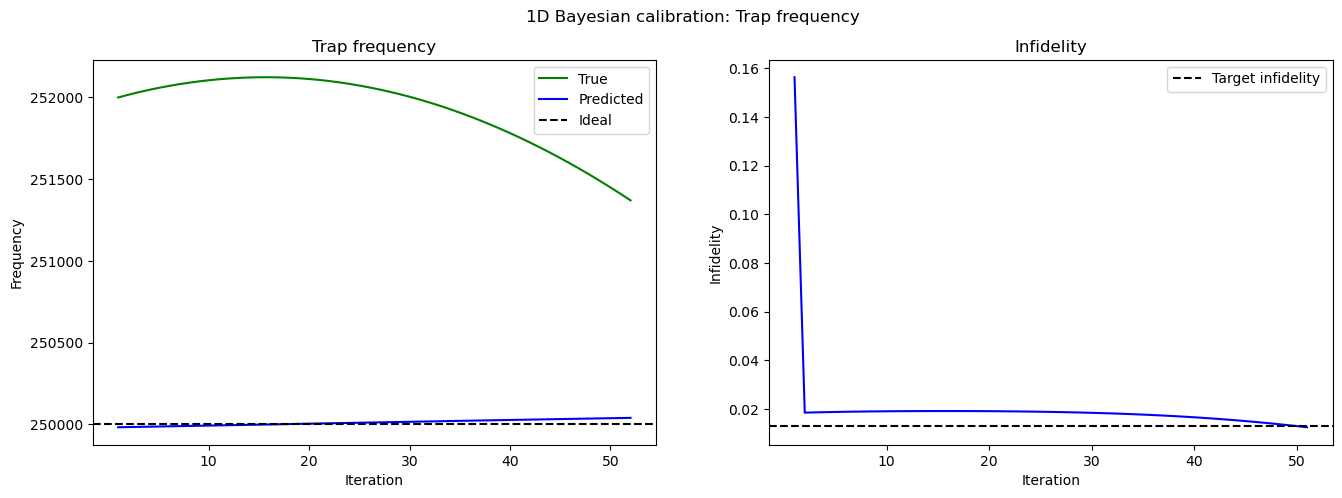

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

ax1.plot(1:length(ŒΩ_tracker), ŒΩ_tracker, color="g", label = "True")
ax1.plot(1:length(ŒΩ_bar_tracker), ŒΩ_bar_tracker, color="b", label = "Predicted")
ax1.axhline(TRAP_FREQUENCY, color="k", linestyle="--", label = "Ideal")
ax1.set_xticks(ticks=[i for i in 1:length(ŒΩ_infid_tracker) if i%10==0])
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Frequency")
ax1.set_title("Trap frequency")
ax1.legend()


ax2.plot(1:length(ŒΩ_infid_tracker), ŒΩ_infid_tracker, color="b")
ax2.axhline(INFID_THRESH, label = "Target infidelity", color="k", linestyle="--")
ax2.set_xticks(ticks=[i for i in 1:length(ŒΩ_infid_tracker) if i%10==0])
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Infidelity")
ax2.set_title("Infidelity")
ax2.legend()

fig.suptitle("1D Bayesian calibration: Trap frequency")

plt.display(fig)
plt.close(fig)

**TODO:** This is weird. Why does fidelity decrease as trap-frequency strays from the "ideal"?

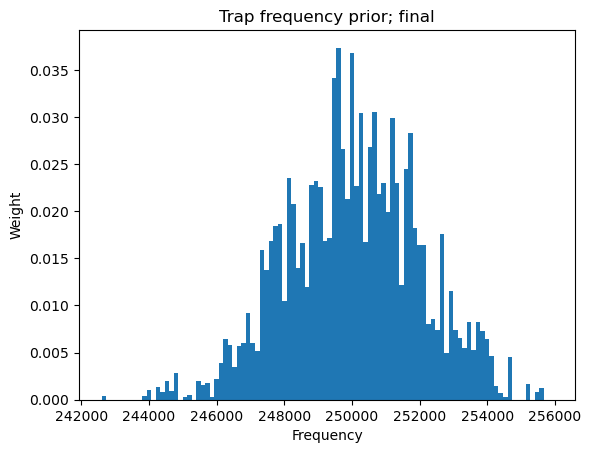

In [70]:
particles_ŒΩ_1d_binned, weights_ŒΩ_1d_binned, binwidth_ŒΩ_1d = bin_prior(particles_ŒΩ_1d, weights_ŒΩ_1d, 100)
fig = plt.figure()
plt.bar(particles_ŒΩ_1d_binned, weights_ŒΩ_1d_binned, width = binwidth_ŒΩ_1d)
plt.xlabel("Frequency")
plt.ylabel("Weight")
plt.title("Trap frequency prior; final")
plt.display(fig)
plt.close(fig)

**Interesting:** Sidebands in the trap-frequency but not the center-line frequency?

Also interesting that it displays such distinct structure after not many (e.g. 6) iterations.

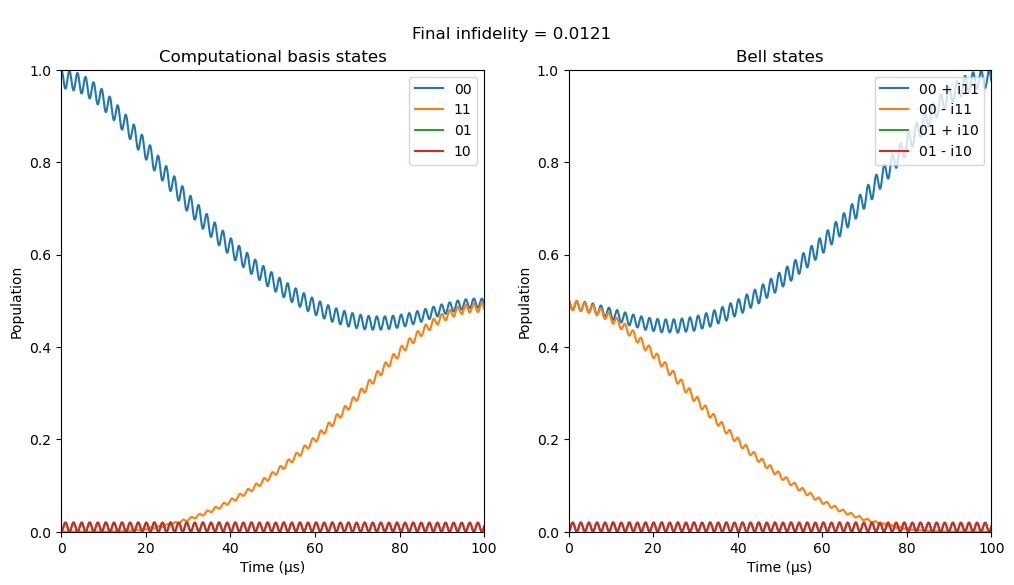

In [71]:
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
œÅ = ptrace(dm(sol[end]),3)
fid = fidelity(œÅ, œÅ_00_p_i11)
infid = 1 - real(fid)

fig = plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)
infid_title = round(infid, digits=4)
plt.suptitle("\nFinal infidelity = $infid_title")
plt.display(fig)
plt.close(fig)

# 4. 1D Bayesian parameter calibration: Phase of lasers

## 4.a. Compute initial prior

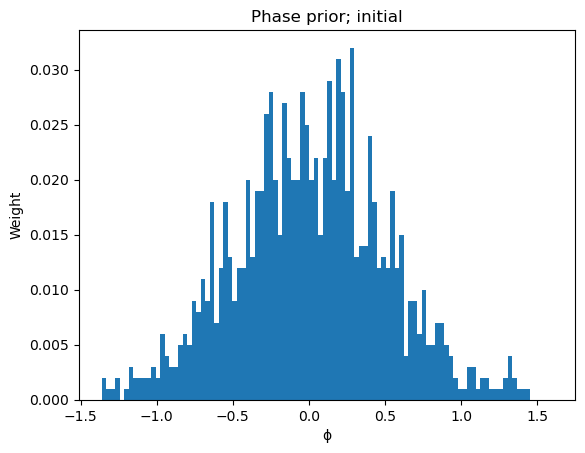

In [72]:
particles_œï_1d = []
weights_œï_1d = []

n_collected_œï_1d = 0
while n_collected_œï_1d < N_PARTICLES
    œï_new = rand(Normal_œï)[1]
    append!(particles_œï_1d, œï_new)
    append!(weights_œï_1d, 1.0)
    n_collected_œï_1d += 1
end

weights_œï_1d = weights_œï_1d ./ sum(weights_œï_1d);

particles_œï_1d_binned, weights_œï_1d_binned, binwidth_œï_1d = bin_prior(particles_œï_1d, weights_œï_1d, 100)
fig = plt.figure()
plt.bar(particles_œï_1d_binned, weights_œï_1d_binned, width = binwidth_œï_1d)
plt.xlabel("œï")
plt.ylabel("Weight")
plt.title("Phase prior; initial")
plt.display(fig)
plt.close(fig)

## 4.b. Compute $P(m|\Theta)$

In [73]:
CONDITIONAL_œï_DIST_COMPUTED = true

true

In [74]:
if CONDITIONAL_œï_DIST_COMPUTED
    m_given_œï_1d_dist = load_csv_to_matrix("m_given_œï_1d_dist_$N_PARTICLES.csv")
else
    MS_CHAMBER_UNTUNED = construct_MS_chamber(
        Œº_ŒΩ,
        Œº_I,
        Œº_f_cl,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH
    )
    phase!(MS_CHAMBER_UNTUNED.lasers[1], 0)

    m_given_œï_1d_dist = zeros((N_PARTICLES, 4))

    for i in 1:length(particles_œï_1d)

        if i%Int(1e2)==0
            print("\n", i)
            flush(stdout)
        end


        œï_i = particles_œï_1d[i]
        phase!(MS_CHAMBER_UNTUNED.lasers[2], œï_i)
        h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
        tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
        œÅ_final = ptrace(dm(sol[end]),3)
        probs = ZZ_probs(œÅ_final)
        probs = probs ./ sum(probs)
        m_given_œï_1d_dist[i, :] = [p for p in probs]
    end
    writedlm("m_given_œï_1d_dist_$N_PARTICLES.csv",  m_given_œï_1d_dist, ',')
    CONDITIONAL_œï_DIST_COMPUTED = true
end;

## 4.c. Calibrate

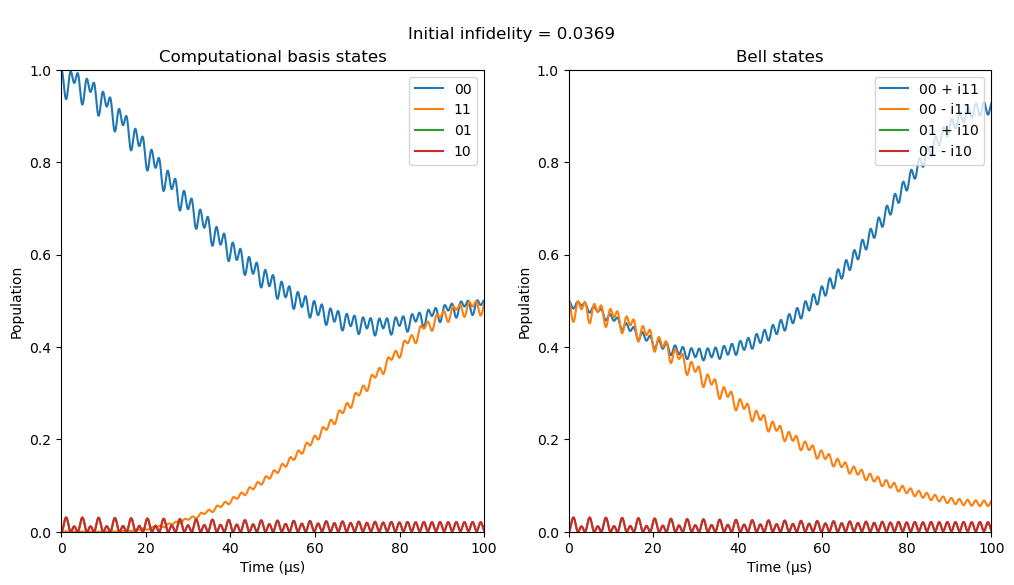

In [75]:
# Initial theta
œï_INITIAL = PHASE + œÉ_œï
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    Œº_ŒΩ,
    Œº_I,
    C0/Œº_f_cl,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
phase!(MS_CHAMBER_UNTUNED.lasers[1], 0)
phase!(MS_CHAMBER_UNTUNED.lasers[2], œï_INITIAL)

# Initial belief about theta
œï_bar = sum(particles_œï_1d .* weights_œï_1d)

# Initial fidelity/infidelity
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
œÅ = ptrace(dm(sol[end]),3)
fid = fidelity(œÅ, œÅ_00_p_i11)
infid = 1 - real(fid)

fig = plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)
infid_title = round(infid, digits=4)
plt.suptitle("\nInitial infidelity = $infid_title")
plt.display(fig)
plt.close(fig)

In [76]:
loop = 0
œï_infid_tracker = []
œï_tracker = [œï_INITIAL]
œï_bar_tracker = [œï_bar]
while infid > INFID_THRESH
    loop += 1
    if loop > MAX_LOOPS
        break
    end

    # Perform measurements 
    h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
    œÅ = ptrace(dm(sol[end]),3)
    fid = fidelity(œÅ, œÅ_00_p_i11)
    infid = 1 - real(fid)
    probs = ZZ_probs(œÅ)
    probs = probs ./ sum(probs)
    m_t = rand(Categorical([p for p in probs]), N_SHOTS)

    # Update beliefs
    for i in 1:N_PARTICLES
        w_i = weights_œï_1d[i]
        theta_i = particles_œï_1d[i]
        p_m_given_œï_1d_dist = m_given_œï_1d_dist[i, :]
        p_m = mean(p_m_given_œï_1d_dist[m_t])
        weights_œï_1d[i] = w_i * p_m
    end
    weights_œï_1d = weights_œï_1d ./ sum(weights_œï_1d)
    œï_bar = sum(particles_œï_1d .* weights_œï_1d)
    
    # Update parameters
    œï_new = compute_œï_new(MS_CHAMBER_UNTUNED, œï_bar)%2œÄ
    update_œï(MS_CHAMBER_UNTUNED, œï_new)

    append!(œï_infid_tracker, infid)
    append!(œï_tracker, œï_new)
    append!(œï_bar_tracker, œï_bar)
    print("\nœï_bar = ", œï_bar, ", œï_new = ", œï_new, ", infid = ", infid)
    flush(stdout)

end


œï_bar = 0.011519174893647757, œï_new = 0.4911356496807192, infid = 0.03694916253635472
œï_bar = 0.011798271115596915, œï_new = 0.4793373785651223, infid = 0.03539748867958514
œï_bar = 0.012048920431521355, œï_new = 0.467288458133601, infid = 0.0338415016356457
œï_bar = 0.012311322505408555, œï_new = 0.4549771356281924, infid = 0.032287335589327615
œï_bar = 0.01254140105317447, œï_new = 0.44243573457501795, infid = 0.03073586853208443
œï_bar = 0.012746052755422236, œï_new = 0.4296896818195957, infid = 0.029193541209041163
œï_bar = 0.01299958756770804, œï_new = 0.4166900942518877, infid = 0.02766561286456093
œï_bar = 0.013258672414839995, œï_new = 0.4034314218370477, infid = 0.02614855104511471
œï_bar = 0.013461783919686736, œï_new = 0.389969637917361, infid = 0.02464431562975289
œï_bar = 0.013681345196072081, œï_new = 0.37628829272128894, infid = 0.0231617136717559
œï_bar = 0.013911250092879563, œï_new = 0.36237704262840936, infid = 0.02170121925552082
œï_bar = 0.014122521668545324, œ

## 4.d. Analyze results

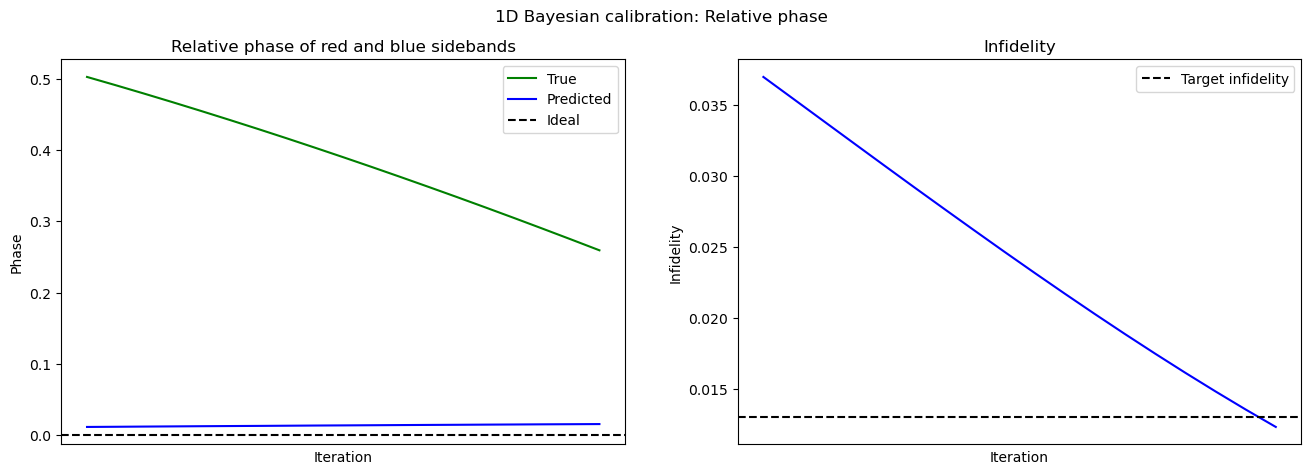

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

ax1.plot(1:length(œï_tracker), œï_tracker, color="g", label = "True")
ax1.plot(1:length(œï_bar_tracker), œï_bar_tracker, color="b", label = "Predicted")
ax1.axhline(PHASE, color="k", linestyle="--", label = "Ideal")
ax1.set_xticks(ticks=[i for i in 1:length(œï_tracker) if i%100==0])
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Phase")
ax1.set_title("Relative phase of red and blue sidebands")
ax1.legend()


ax2.plot(1:length(œï_infid_tracker), œï_infid_tracker, color="b")
ax2.axhline(INFID_THRESH, label = "Target infidelity", color="k", linestyle="--")
ax2.set_xticks(ticks=[i for i in 1:length(œï_infid_tracker) if i%100==0])
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Infidelity")
ax2.set_title("Infidelity")
ax2.legend()

fig.suptitle("1D Bayesian calibration: Relative phase")

plt.display(fig)
plt.close(fig)

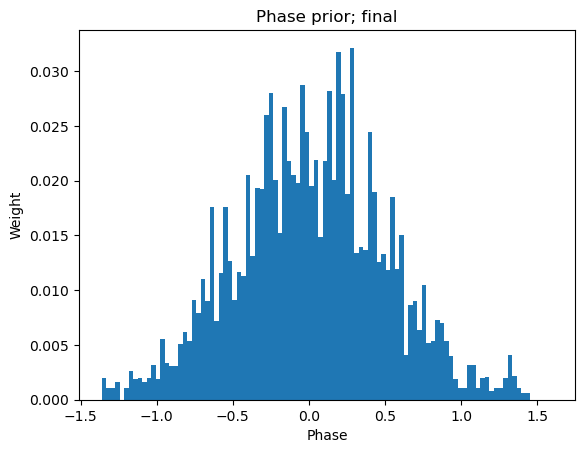

In [78]:
particles_œï_1d_binned, weights_œï_1d_binned, binwidth_œï_1d = bin_prior(particles_œï_1d, weights_œï_1d, 100)
fig = plt.figure()
plt.bar(particles_œï_1d_binned, weights_œï_1d_binned, width = binwidth_œï_1d)
plt.xlabel("Phase")
plt.ylabel("Weight")
plt.title("Phase prior; final")
plt.display(fig)
plt.close(fig)

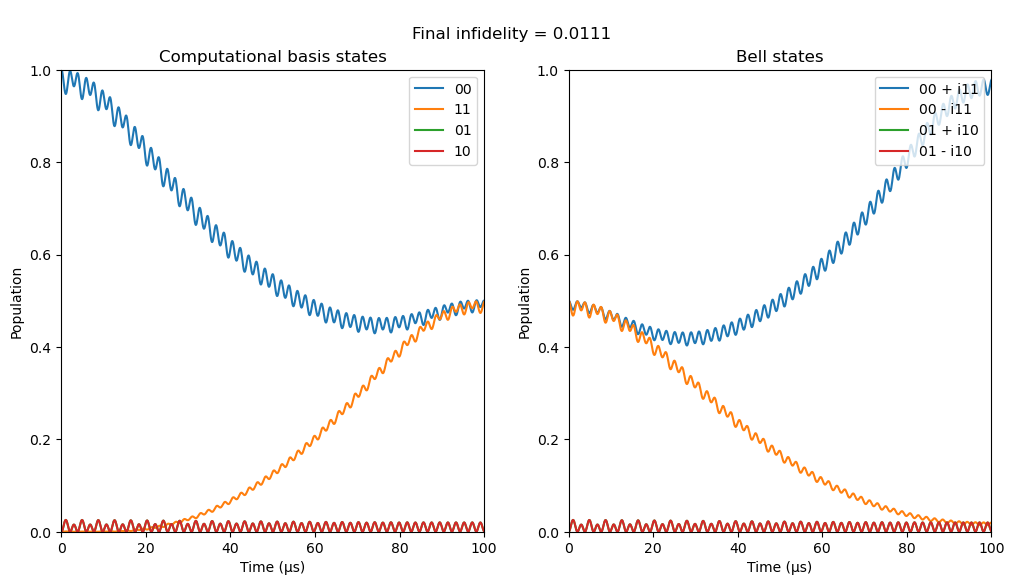

In [79]:
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
œÅ = ptrace(dm(sol[end]),3)
fid = fidelity(œÅ, œÅ_00_p_i11)
infid = 1 - real(fid)

fig = plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)
infid_title = round(infid, digits=4)
plt.suptitle("\nFinal infidelity = $infid_title")
plt.display(fig)
plt.close(fig)